In [1]:
import numpy as np
from matplotlib import pyplot as plt

from pyloki.config import ParamLimits, PulsarSearchConfig
from pyloki.core.taylor import generate_branching_pattern
from pyloki.detection import thresholding
from pyloki.ffa import DynamicProgramming
from pyloki.periodogram import PruningStatsPlotter, ScatteredPeriodogram
from pyloki.prune import prune_dyp_tree
from pyloki.simulation.pulse import PulseSignalConfig

tobs = 2147.483648


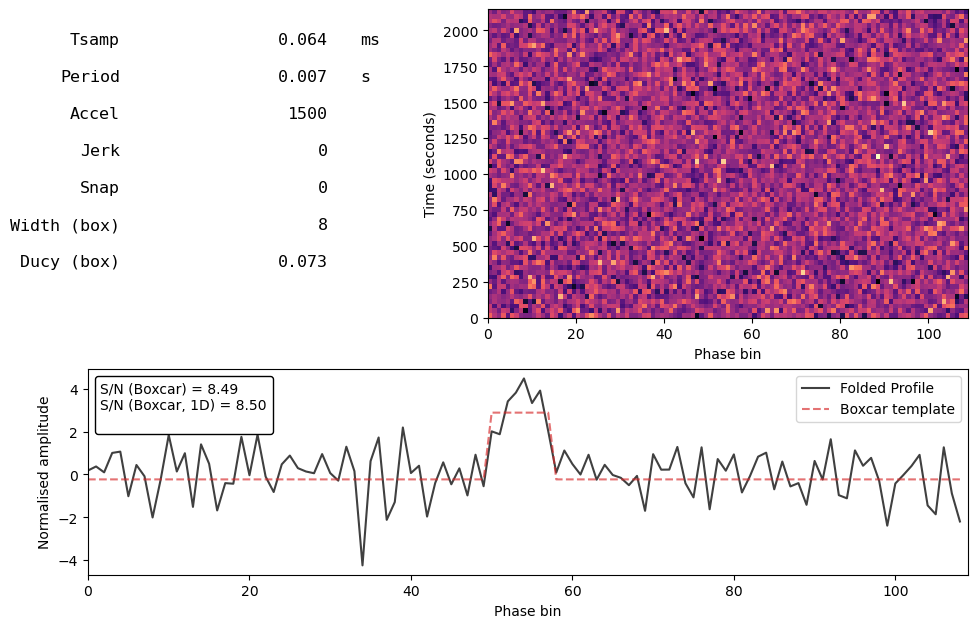

In [2]:
pulsar_period = 0.007
dt = 64e-6
accel = 1500         
nsamps = 2**25
mod_kwargs = {"acc": accel}
cfg = PulseSignalConfig(period=pulsar_period, dt=dt, nsamps=nsamps, snr=8.5, ducy=0.1, mod_kwargs=mod_kwargs)
print(f"tobs = {cfg.tobs}")
tim_data = cfg.generate(shape="gaussian")
tim_data.plot_fold(cfg.freq, cfg.fold_bins, mod_kwargs=mod_kwargs)
plt.show()

In [3]:
tol_bins = 1 #cfg.tol_bins
fold_bins = 64 #cfg.fold_bins
p = ParamLimits.from_taylor((140.0, 145.0), (-2500.0, 2500.0) )
print(f"Param limits: {p.limits}")
bseg_brute = cfg.nsamps // 8192
bseg_ffa = cfg.nsamps // 128
search_cfg = PulsarSearchConfig(nsamps=cfg.nsamps, tsamp=cfg.dt, nbins=fold_bins, tol_bins=tol_bins, param_limits=p.limits,
                                bseg_brute=bseg_brute, bseg_ffa=bseg_ffa, prune_poly_order=2, ducy_max=0.2, wtsp=1.5, use_fft_shifts=True)
dyp = DynamicProgramming(tim_data, search_cfg)
dyp.initialize()
dyp.execute()

Param limits: [(-2500.0, 2500.0), (140.0, 145.0)]


2025-08-18 17:47:28 INFO     - pyloki.ffa - FFA initialize: Grid sizes: [7.52164558e+06 1.19209290e-01]

2025-08-18 17:47:30 INFO     - pyloki.ffa - ffa level:  0, leaves: 5.36, fold dims: (8192, 1, 41, 2, 33)

                    INFO     - pyloki.ffa - ffa_initialize finished, Elapsed time: 1.331 seconds

Output()

2025-08-18 17:47:33 INFO     - pyloki.ffa - ffa level:  1, leaves:  6.38, fold dims: (4096, 1, 83, 2, 33)

                    INFO     - pyloki.ffa - ffa level:  2, leaves:  7.38, fold dims: (2048, 1, 167, 2, 33)

                    INFO     - pyloki.ffa - ffa level:  3, leaves:  8.39, fold dims: (1024, 1, 335, 2, 33)

                    INFO     - pyloki.ffa - ffa level:  4, leaves:  9.39, fold dims: (512, 1, 671, 2, 33)

                    INFO     - pyloki.ffa - ffa level:  5, leaves: 10.39, fold dims: (256, 1, 1342, 2, 33)

                    INFO     - pyloki.ffa - FFA complete: Grid sizes: [1.83633925e+03 1.86264515e-03]

                    INFO     - pyloki.ffa - ffa_execute finished, Elapsed time: 3.361 seconds

In [4]:
branching_pattern = generate_branching_pattern(dyp.param_arr, dyp.dparams_limited, dyp.cfg.param_limits, dyp.cfg.tseg_ffa, dyp.nsegments - 1,
                                               dyp.cfg.nbins, dyp.cfg.tol_bins)
branching_pattern

array([8.        , 3.        , 2.        , 3.        , 1.        ,
       1.        , 2.        , 3.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 3.        , 2.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 3.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       2.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 3.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 2.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

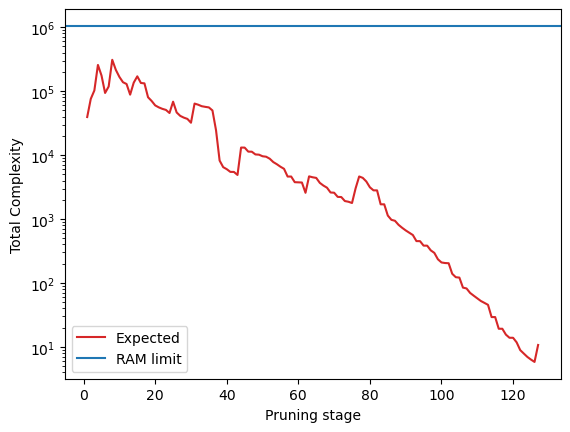

In [5]:
thresholds = np.array([2.1, 2.5, 2.6, 2.5, 2.7, 3. , 3.1, 2.9, 3.1, 3.1, 3.1, 2.9, 3.2,
       3.5, 3.6, 3.6, 3.2, 3.7, 3.6, 3.6, 3.5, 3.4, 3.3, 3.4, 3.9, 4. ,
       3.9, 3.8, 3.7, 3.8, 3.5, 3.6, 3.6, 3.5, 3.4, 3.6, 4.1, 4.5, 4.5,
       4.4, 4.4, 4. , 4.3, 4.3, 4. , 4.3, 4. , 4.2, 4. , 4.1, 4. , 4.1,
       4.2, 4.2, 4.2, 4.2, 4.4, 4. , 4.4, 4.2, 4.1, 4.5, 4.5, 4.4, 4.3,
       4.5, 4.5, 4.5, 4.6, 4.4, 4.6, 4.4, 4.6, 4.5, 4.5, 4.6, 4.4, 4.5,
       4.6, 4.7, 4.7, 4.4, 4.9, 4.5, 5. , 5. , 4.9, 5. , 5. , 5. , 5. ,
       5. , 5.1, 4.9, 5.1, 4.9, 5.1, 5.1, 5.2, 5.2, 5.1, 5. , 5.3, 5.3,
       5.2, 5.4, 5.3, 5.4, 5.4, 5.4, 5.4, 5.4, 5.4, 5.6, 5.3, 5.7, 5.3,
       5.7, 5.7, 5.3, 5.7, 5.8, 5.8, 5.8, 5.8, 5.8, 5.8])
thresh_state = thresholding.evaluate_scheme(thresholds, branching_pattern, ref_ducy=0.1, nbins=64,
                                            ntrials=1024, snr_final=8.5, ducy_max=0.2, wtsp=1.5)
x = np.arange(1, len(branching_pattern) + 1)
plt.semilogy(x, np.array(thresh_state.get_info("complexity")) * dyp.nparam_vol, label="Expected", c="tab:red")
plt.axhline(2**20, label="RAM limit", c="tab:blue")
plt.xlabel("Pruning stage")
plt.ylabel("Total Complexity")
plt.legend()
plt.show()

In [6]:
result_file = prune_dyp_tree(dyp, thresholds, n_runs=32, max_sugg=2**20, outdir="accel_test/", file_prefix="test_accel",
                             kind="taylor", n_workers=8)

2025-08-18 17:47:37 INFO     - pyloki.prune - Starting Pruning for 32 runs, with 8 workers

Output()

2025-08-18 17:47:43 INFO     - worker_000 - Initializing pruning run with ref segment: 0

2025-08-18 17:47:45 INFO     - worker_004 - Initializing pruning run with ref segment: 4

2025-08-18 17:47:48 INFO     - worker_008 - Initializing pruning run with ref segment: 8

2025-08-18 17:47:49 INFO     - worker_000 - prune_initialize finished, Elapsed time: 5.392 seconds

                    INFO     - worker_008 - prune_initialize finished, Elapsed time: 0.740 seconds

2025-08-18 17:47:50 INFO     - worker_004 - prune_initialize finished, Elapsed time: 4.692 seconds

2025-08-18 17:47:51 INFO     - worker_012 - Initializing pruning run with ref segment: 12

                    INFO     - worker_012 - prune_initialize finished, Elapsed time: 0.047 seconds

2025-08-18 17:47:54 INFO     - worker_016 - Initializing pruning run with ref segment: 16

                    INFO     - worker_016 - prune_initialize finished, Elapsed time: 0.042 seconds

2025-08-18 17:47:58 INFO     - worker_020 - Initializing pruning run with ref segment: 20

                    INFO     - worker_020 - prune_initialize finished, Elapsed time: 0.041 seconds

                    INFO     - worker_025 - prune_initialize finished, Elapsed time: 0.044 seconds

2025-08-18 17:48:05 INFO     - worker_029 - Initializing pruning run with ref segment: 29

                    INFO     - worker_029 - prune_initialize finished, Elapsed time: 0.046 seconds

2025-08-18 17:48:15 INFO     - worker_000 - Pruning run complete for ref segment: 0

                    INFO     - worker_000 - Pruning stats: Score: 6.31, Leaves: 3.32

                    INFO     - worker_008 - Pruning run complete for ref segment: 8

                    INFO     - worker_008 - Pruning stats: Score: 7.78, Leaves: 5.39

                    INFO     - worker_008 - Pruning time: Total: 5.8s (score: 42% | shift_add: 18% | threshold: 16%
                             | branch: 13%)

                    INFO     - worker_016 - Pruning run complete for ref segment: 16

                    INFO     - worker_016 - Pruning stats: Score: 6.67, Leaves: 4.91

                    INFO     - worker_016 - Pruning time: Total: 5.8s (score: 42% | shift_add: 18% | threshold: 16%
                             | branch: 13%)

2025-08-18 17:48:16 INFO     - worker_012 - Pruning run complete for ref segment: 12

                    INFO     - worker_012 - Pruning stats: Score: 7.91, Leaves: 6.49

                    INFO     - worker_012 - Pruning time: Total: 5.6s (score: 42% | shift_add: 19% | threshold: 16%
                             | branch: 12%)

                    INFO     - worker_004 - Pruning run complete for ref segment: 4

                    INFO     - worker_004 - Pruning stats: Score: 6.42, Leaves: 4.32

                    INFO     - worker_004 - Pruning time: Total: 5.4s (score: 42% | shift_add: 19% | threshold: 16%
                             | branch: 13%)

2025-08-18 17:48:17 INFO     - worker_020 - Pruning run complete for ref segment: 20

                    INFO     - worker_020 - Pruning stats: Score: 6.51, Leaves: 3.81

                    INFO     - worker_020 - Pruning time: Total: 6.0s (score: 42% | shift_add: 18% | threshold: 15%
                             | branch: 13%)

2025-08-18 17:48:18 INFO     - worker_025 - Pruning run complete for ref segment: 25

                    INFO     - worker_025 - Pruning stats: Score: 7.98, Leaves: 6.43

                    INFO     - worker_025 - Pruning time: Total: 5.5s (score: 42% | shift_add: 18% | threshold: 16%
                             | branch: 13%)

                    INFO     - worker_033 - Initializing pruning run with ref segment: 33

                    INFO     - worker_033 - prune_initialize finished, Elapsed time: 0.011 seconds

2025-08-18 17:48:20 INFO     - worker_029 - Pruning run complete for ref segment: 29

                    INFO     - worker_029 - Pruning stats: Score: 7.47, Leaves: 5.64

                    INFO     - worker_029 - Pruning time: Total: 5.0s (score: 43% | shift_add: 18% | threshold: 15%
                             | branch: 13%)

                    INFO     - worker_037 - prune_initialize finished, Elapsed time: 0.011 seconds

2025-08-18 17:48:23 INFO     - worker_033 - Pruning run complete for ref segment: 33

                    INFO     - worker_033 - Pruning stats: Score: 6.89, Leaves: 4.81

                    INFO     - worker_033 - Pruning time: Total: 4.6s (score: 45% | shift_add: 19% | threshold: 16%
                             | resolve: 12%)

2025-08-18 17:48:24 INFO     - worker_041 - Initializing pruning run with ref segment: 41

                    INFO     - worker_041 - prune_initialize finished, Elapsed time: 0.010 seconds

                    INFO     - worker_037 - Pruning stats: Score: 7.68, Leaves: 5.81

                    INFO     - worker_037 - Pruning time: Total: 4.9s (score: 43% | shift_add: 18% | threshold: 15%
                             | branch: 13%)

                    INFO     - worker_045 - Initializing pruning run with ref segment: 45

                    INFO     - worker_045 - prune_initialize finished, Elapsed time: 0.011 seconds

2025-08-18 17:48:29 INFO     - worker_041 - Pruning run complete for ref segment: 41

                    INFO     - worker_041 - Pruning stats: Score: 6.08, Leaves: 2.58

                    INFO     - worker_041 - Pruning time: Total: 4.8s (score: 43% | shift_add: 18% | threshold: 15%
                             | branch: 13%)

2025-08-18 17:48:31 INFO     - worker_045 - Pruning run complete for ref segment: 45

                    INFO     - worker_045 - Pruning stats: Score: 6.73, Leaves: 3.32

                    INFO     - worker_045 - Pruning time: Total: 4.4s (score: 43% | shift_add: 17% | threshold: 15%
                             | branch: 13%)

                    INFO     - worker_049 - prune_initialize finished, Elapsed time: 0.011 seconds

                    INFO     - worker_053 - prune_initialize finished, Elapsed time: 0.012 seconds

                    INFO     - worker_057 - prune_initialize finished, Elapsed time: 0.013 seconds

                    INFO     - worker_049 - Pruning run complete for ref segment: 49

                    INFO     - worker_049 - Pruning stats: Score: 7.29, Leaves: 5.25

                    INFO     - worker_049 - Pruning time: Total: 5.2s (score: 43% | shift_add: 17% | threshold: 15%
                             | branch: 13%)

                    INFO     - worker_061 - prune_initialize finished, Elapsed time: 0.012 seconds

                    INFO     - worker_053 - Pruning run complete for ref segment: 53

                    INFO     - worker_053 - Pruning stats: Score: 7.71, Leaves: 5.32

                    INFO     - worker_053 - Pruning time: Total: 5.1s (score: 43% | shift_add: 18% | threshold: 14%
                             | branch: 14%)

2025-08-18 17:48:44 INFO     - worker_057 - Pruning run complete for ref segment: 57

                    INFO     - worker_057 - Pruning stats: Score: 6.48, Leaves: 3.58

                    INFO     - worker_057 - Pruning time: Total: 4.8s (score: 43% | shift_add: 18% | threshold: 15%
                             | branch: 13%)

                    INFO     - worker_066 - prune_initialize finished, Elapsed time: 0.012 seconds

2025-08-18 17:48:47 INFO     - worker_061 - Pruning run complete for ref segment: 61

                    INFO     - worker_061 - Pruning stats: Score: 6.61, Leaves: 5.00

                    INFO     - worker_061 - Pruning time: Total: 5.0s (score: 44% | shift_add: 17% | threshold: 15%
                             | branch: 13%)

                    INFO     - worker_070 - prune_initialize finished, Elapsed time: 0.011 seconds

2025-08-18 17:48:51 INFO     - worker_066 - Pruning run complete for ref segment: 66

                    INFO     - worker_066 - Pruning stats: Score: 6.65, Leaves: 4.00

                    INFO     - worker_066 - Pruning time: Total: 4.5s (score: 45% | shift_add: 19% | threshold: 16%
                             | resolve: 12%)

2025-08-18 17:48:53 INFO     - worker_074 - Initializing pruning run with ref segment: 74

                    INFO     - worker_074 - prune_initialize finished, Elapsed time: 0.010 seconds

2025-08-18 17:48:55 INFO     - worker_070 - Pruning run complete for ref segment: 70

                    INFO     - worker_070 - Pruning stats: Score: 6.17, Leaves: 2.00

                    INFO     - worker_070 - Pruning time: Total: 4.7s (score: 43% | shift_add: 18% | threshold: 15%
                             | branch: 13%)

2025-08-18 17:48:58 INFO     - worker_074 - Pruning run complete for ref segment: 74

                    INFO     - worker_074 - Pruning stats: Score: 8.34, Leaves: 4.91

                    INFO     - worker_074 - Pruning time: Total: 4.4s (score: 44% | shift_add: 17% | threshold: 15%
                             | branch: 13%)

2025-08-18 17:49:00 INFO     - worker_078 - Initializing pruning run with ref segment: 78

                    INFO     - worker_078 - prune_initialize finished, Elapsed time: 0.011 seconds

                    INFO     - worker_082 - prune_initialize finished, Elapsed time: 0.011 seconds

2025-08-18 17:49:05 INFO     - worker_078 - Pruning run complete for ref segment: 78

                    INFO     - worker_078 - Pruning stats: Score: 6.54, Leaves: 4.17

                    INFO     - worker_078 - Pruning time: Total: 5.0s (score: 43% | shift_add: 18% | threshold: 15%
                             | branch: 13%)

                    INFO     - worker_086 - prune_initialize finished, Elapsed time: 0.011 seconds

2025-08-18 17:49:08 INFO     - worker_082 - Pruning run complete for ref segment: 82

                    INFO     - worker_082 - Pruning stats: Score: 6.34, Leaves: 3.58

                    INFO     - worker_082 - Pruning time: Total: 5.3s (score: 43% | shift_add: 18% | threshold: 15%
                             | branch: 13%)

2025-08-18 17:49:12 INFO     - worker_086 - Pruning run complete for ref segment: 86

                    INFO     - worker_086 - Pruning stats: Score: 6.57, Leaves: 5.32

                    INFO     - worker_086 - Pruning time: Total: 5.1s (score: 44% | shift_add: 17% | threshold: 14%
                             | branch: 13%)

                    INFO     - worker_090 - prune_initialize finished, Elapsed time: 0.011 seconds

2025-08-18 17:49:18 INFO     - worker_090 - Pruning run complete for ref segment: 90

                    INFO     - worker_090 - Pruning stats: Score: 6.32, Leaves: 4.91

                    INFO     - worker_090 - Pruning time: Total: 4.9s (score: 44% | shift_add: 17% | threshold: 15%
                             | branch: 13%)

                    INFO     - worker_094 - prune_initialize finished, Elapsed time: 0.010 seconds

                    INFO     - worker_098 - prune_initialize finished, Elapsed time: 0.011 seconds

2025-08-18 17:49:28 INFO     - worker_094 - Pruning run complete for ref segment: 94

                    INFO     - worker_094 - Pruning stats: Score: 6.13, Leaves: 3.81

                    INFO     - worker_094 - Pruning time: Total: 4.9s (score: 44% | shift_add: 17% | threshold: 15%
                             | branch: 13%)

                    INFO     - worker_102 - prune_initialize finished, Elapsed time: 0.011 seconds

2025-08-18 17:49:31 INFO     - worker_098 - Pruning run complete for ref segment: 98

                    INFO     - worker_098 - Pruning stats: Score: 6.32, Leaves: 4.00

                    INFO     - worker_098 - Pruning time: Total: 4.4s (score: 45% | shift_add: 19% | threshold: 15%
                             | resolve: 12%)

2025-08-18 17:49:34 INFO     - worker_102 - Pruning run complete for ref segment: 102

                    INFO     - worker_102 - Pruning stats: Score: 6.14, Leaves: 4.46

                    INFO     - worker_102 - Pruning time: Total: 4.7s (score: 43% | shift_add: 17% | threshold: 15%
                             | branch: 13%)

                    INFO     - worker_107 - prune_initialize finished, Elapsed time: 0.010 seconds

2025-08-18 17:49:43 INFO     - worker_107 - Pruning run complete for ref segment: 107

                    INFO     - worker_107 - Pruning stats: Score: 6.50, Leaves: 3.81

                    INFO     - worker_107 - Pruning time: Total: 4.5s (score: 44% | shift_add: 16% | threshold: 15%
                             | branch: 13%)

2025-08-18 17:49:44 INFO     - worker_111 - Initializing pruning run with ref segment: 111

                    INFO     - worker_111 - prune_initialize finished, Elapsed time: 0.009 seconds

2025-08-18 17:49:49 INFO     - worker_115 - Initializing pruning run with ref segment: 115

                    INFO     - worker_115 - prune_initialize finished, Elapsed time: 0.058 seconds

2025-08-18 17:49:50 INFO     - worker_111 - Pruning run complete for ref segment: 111

                    INFO     - worker_111 - Pruning stats: Score: 6.45, Leaves: 3.58

                    INFO     - worker_111 - Pruning time: Total: 4.9s (score: 45% | threshold: 17% | shift_add: 15%
                             | branch: 13%)

2025-08-18 17:49:51 INFO     - worker_119 - Initializing pruning run with ref segment: 119

                    INFO     - worker_119 - prune_initialize finished, Elapsed time: 0.010 seconds

2025-08-18 17:49:54 INFO     - worker_123 - Initializing pruning run with ref segment: 123

                    INFO     - worker_123 - prune_initialize finished, Elapsed time: 0.012 seconds

2025-08-18 17:49:56 INFO     - worker_115 - Pruning run complete for ref segment: 115

                    INFO     - worker_115 - Pruning stats: Score: 6.57, Leaves: 3.58

                    INFO     - worker_115 - Pruning time: Total: 6.4s (score: 44% | threshold: 20% | shift_add: 14%
                             | branch: 12%)

2025-08-18 17:49:58 INFO     - worker_127 - Initializing pruning run with ref segment: 127

                    INFO     - worker_127 - prune_initialize finished, Elapsed time: 0.011 seconds

                    INFO     - worker_119 - Pruning run complete for ref segment: 119

                    INFO     - worker_119 - Pruning stats: Score: 6.62, Leaves: 3.81

                    INFO     - worker_119 - Pruning time: Total: 6.3s (score: 42% | threshold: 19% | shift_add: 16%
                             | branch: 12%)

2025-08-18 17:50:01 INFO     - worker_123 - Pruning run complete for ref segment: 123

                    INFO     - worker_123 - Pruning stats: Score: 6.17, Leaves: 3.32

                    INFO     - worker_123 - Pruning time: Total: 6.3s (score: 42% | threshold: 21% | shift_add: 15%
                             | branch: 12%)

2025-08-18 17:50:03 INFO     - worker_127 - Pruning run complete for ref segment: 127

                    INFO     - worker_127 - Pruning stats: Score: 6.81, Leaves: 3.81

                    INFO     - worker_127 - Pruning time: Total: 5.4s (score: 44% | threshold: 18% | shift_add: 15%
                             | branch: 12%)

2025-08-18 17:50:05 INFO     - pyloki.prune - Pruning complete. Results saved to                                   
                             accel_test/test_accel_pruning_nstages_128_results.h5

In [7]:
pgram = ScatteredPeriodogram.load(result_file)
print(f"True params, a: {cfg.mod_kwargs["acc"]:.3f}, f: {cfg.freq:.10f}")
print(pgram.get_summary_cands(10, run_id=None))

True params, a: 1500.000, f: 142.8571428571
Top candidates:
dparams: daccel: 0.2099153238, dfreq: 1.455191523e-05
Run: 074_19, S/N: 8.34, accel: 1501.39, freq: 142.857147
Run: 074_19, S/N: 8.32, accel: 1501.39, freq: 142.857132
Run: 074_19, S/N: 8.03, accel: 1501.60, freq: 142.857150
Run: 074_19, S/N: 8.01, accel: 1501.60, freq: 142.857164
Run: 025_07, S/N: 7.98, accel: 1495.30, freq: 142.857145
Run: 025_07, S/N: 7.96, accel: 1495.30, freq: 142.857160
Run: 074_19, S/N: 7.92, accel: 1501.39, freq: 142.857161
Run: 012_04, S/N: 7.91, accel: 1493.62, freq: 142.857173
Run: 012_04, S/N: 7.86, accel: 1493.62, freq: 142.857158
Run: 074_19, S/N: 7.82, accel: 1501.39, freq: 142.857176


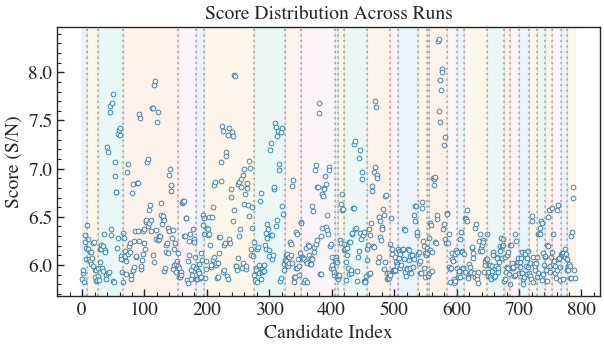

In [8]:
pgram.plot_scores(kind="scatter", run_id=None)
plt.show()

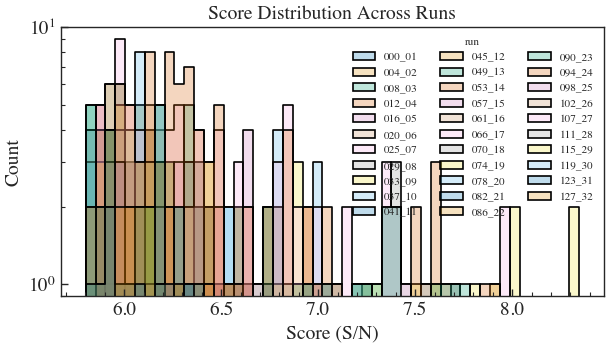

In [9]:
pgram.plot_scores(kind="hist", run_id=None)
plt.show()

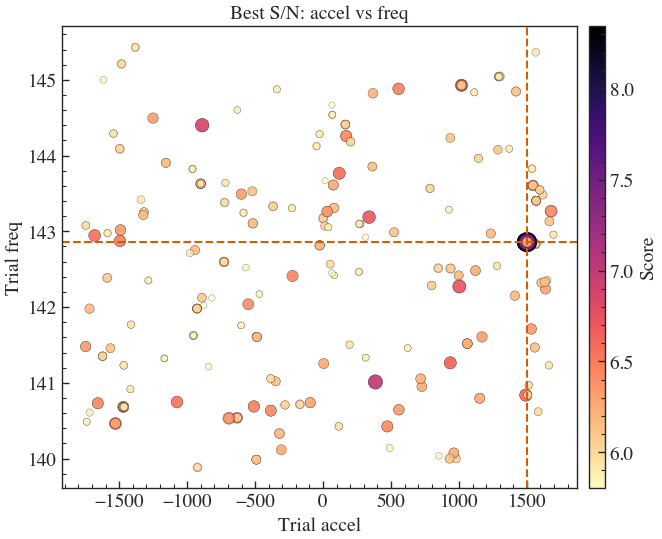

In [10]:
pgram.plot_correlation("accel", "freq", true_values={"accel": cfg.mod_kwargs["acc"], "freq": cfg.freq}, run_id=None)
plt.show()

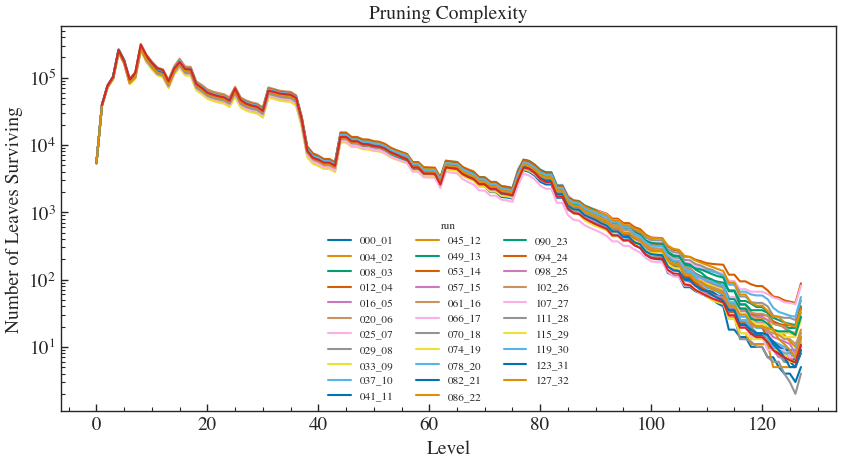

In [11]:
pstats = PruningStatsPlotter.load(result_file)
fig = pstats.plot_level_stats(run_id=None)
x = np.arange(1, len(branching_pattern) + 1)
ax_list = fig.axes
ax_list[0].plot(x, np.array(thresh_state.get_info("complexity")) * dyp.nparam_vol, label="Expected", c="tab:red")
plt.show()